In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Random generation of time series with linear dependencies

In [4]:
length = 100000
train_length = 80000

In [5]:
max_lag = 250
min_number_of_ts = 5
max_number_of_ts = 15
coefficients_scaling = 0.4
number_of_experiments = 10

In [6]:
def generate_timeseries(n_experiments):
    result_ts = []
    targets = []
    configs = []
    for i in range(n_experiments):
        np.random.seed(i*100)
        n_ts = np.random.randint(min_number_of_ts, max_number_of_ts+1)
        X = np.random.randn(length, n_ts)
        regr_dict = {}
        lags_dict = {}
        sign_dict = {}
        coef_dict = {}
        for i in range(n_ts):
            n_coupled = np.random.randint(0, n_ts)
            regressors = np.random.choice(np.arange(0, n_ts), n_coupled, replace=False)
            regr_dict[i] = regressors
            lags = np.random.choice(np.arange(1, max_lag), n_coupled, replace=False)
            lags_dict[i] = lags
            sign_dict[i] = []
            for k in range(n_coupled):
                sign = np.random.randint(0, 2)
                sign = sign*2 - 1
                sign_dict[i].append(sign)
            coefs = np.random.rand(n_coupled)*coefficients_scaling
            coef_dict[i] = coefs
            
        for j in range(length):
            for i in range(n_ts):
                for regr, lag, sign, coef in zip(regr_dict[i], lags_dict[i], sign_dict[i], coef_dict[i]):
                    X[j, i] += sign*coef*X[j-lag, regr]
        result_ts.append(X)
        target = np.random.randint(0, n_ts)
        while len(regr_dict[target]) == 0:
            target = np.random.randint(0, n_ts)
        targets.append(target)
        configs.append([regr_dict, lags_dict, sign_dict, coef_dict])
    return result_ts, targets, configs

In [7]:
import numpy as np

In [8]:
Xs, targets, configs = generate_timeseries(number_of_experiments)

### Examples of generated time series

0 0


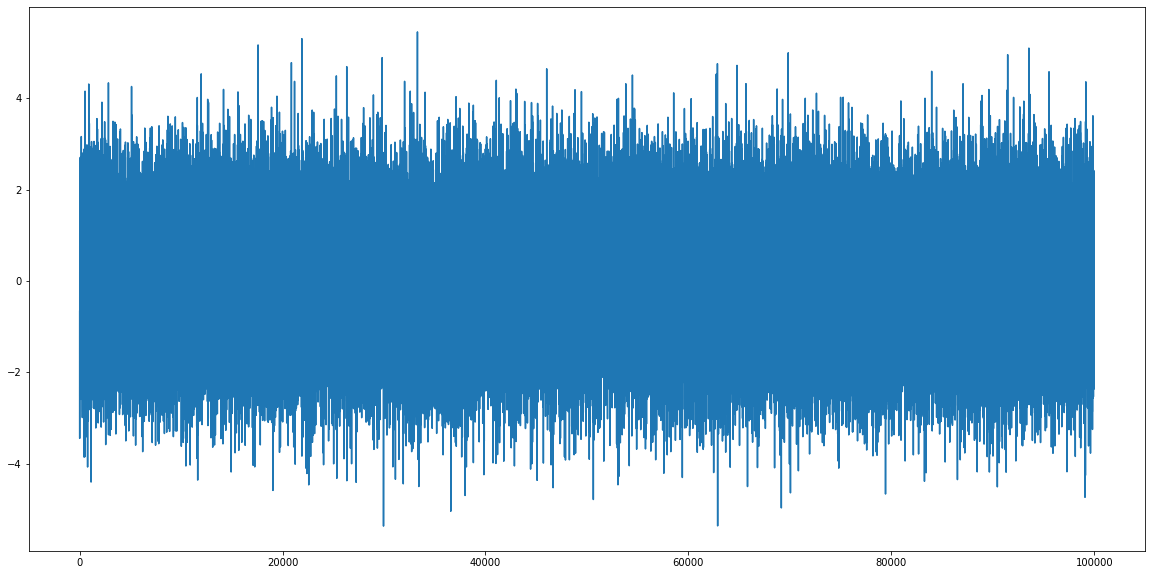

1 0


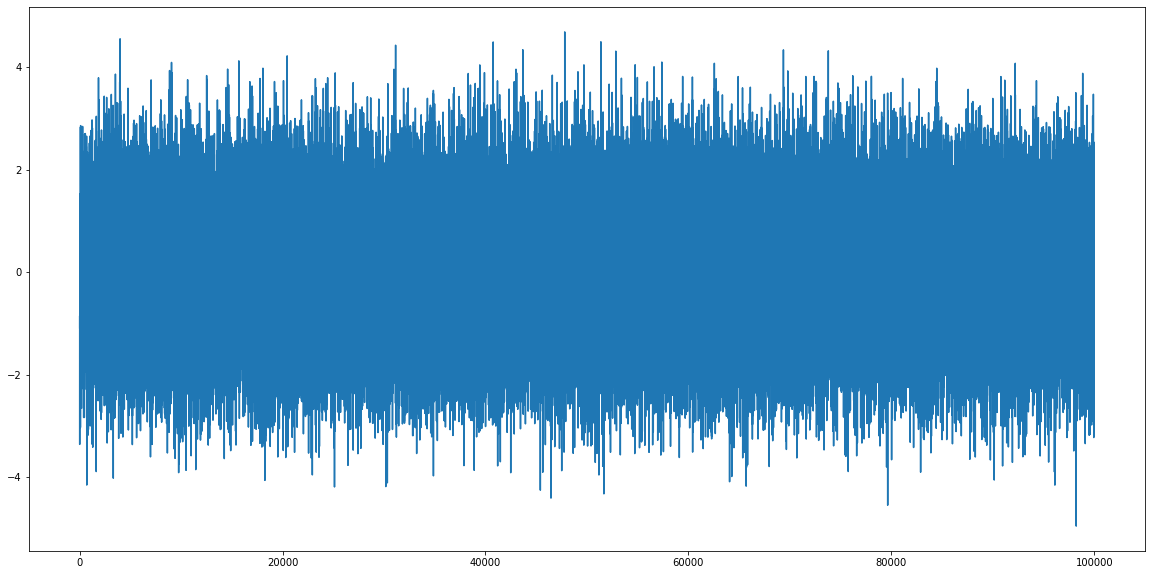

2 0


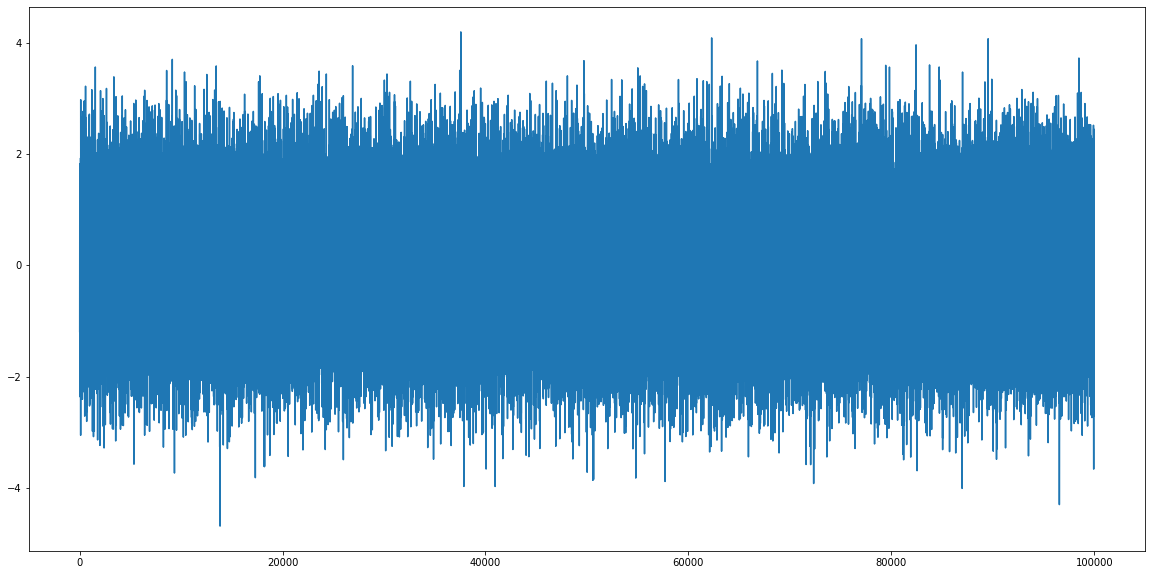

3 0


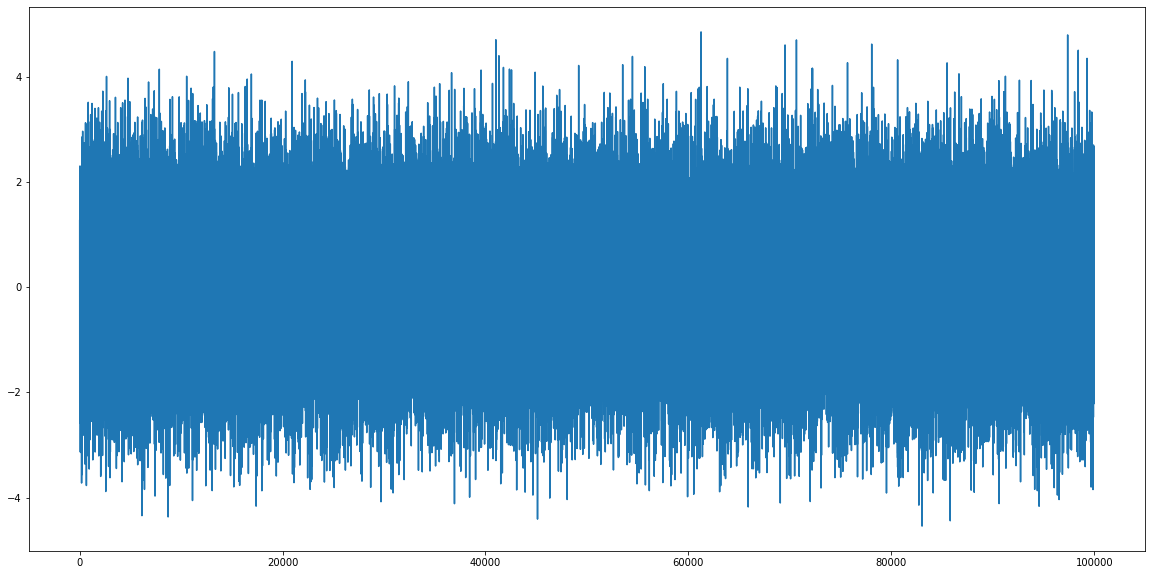

4 0


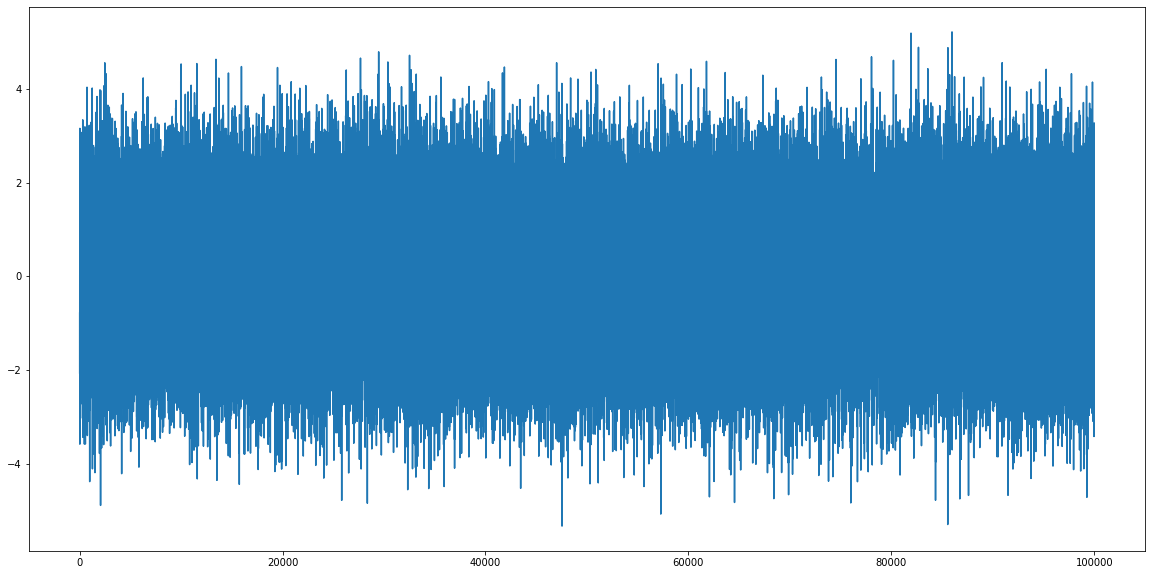

5 0


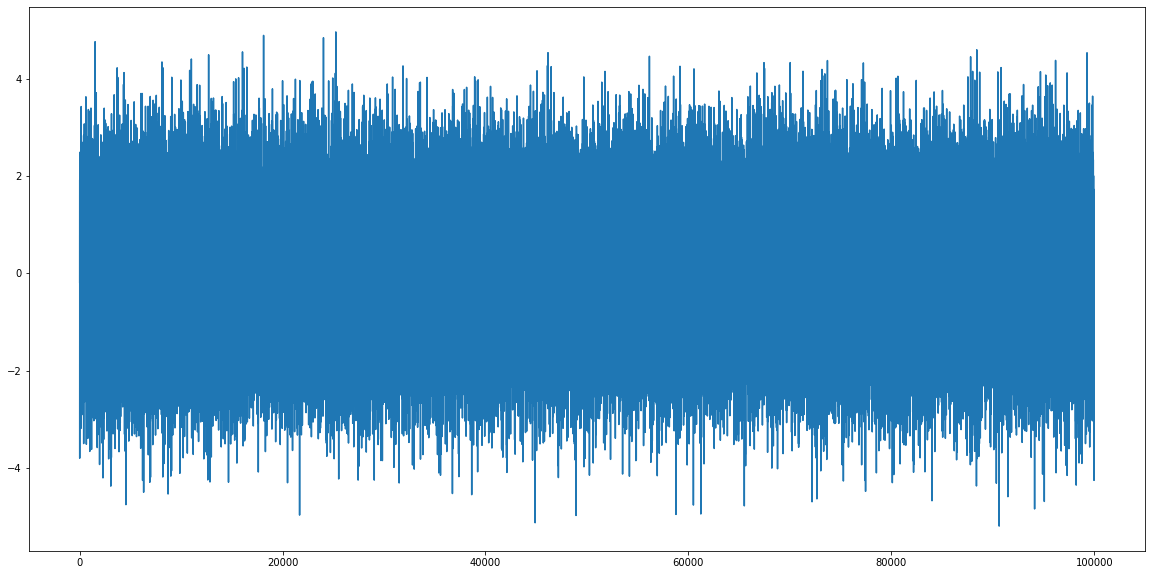

6 0


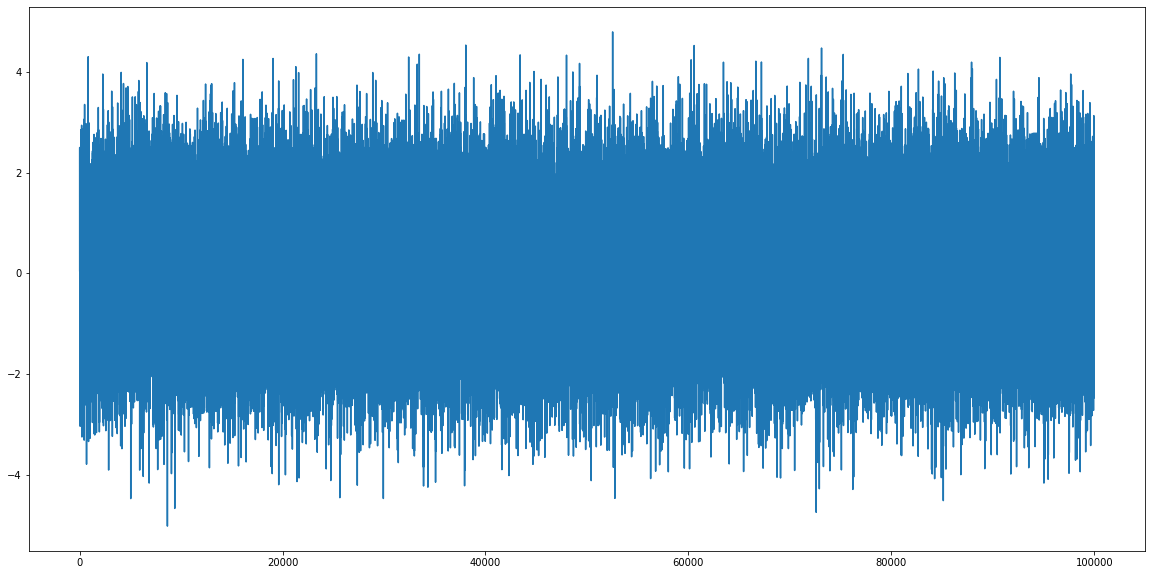

7 0


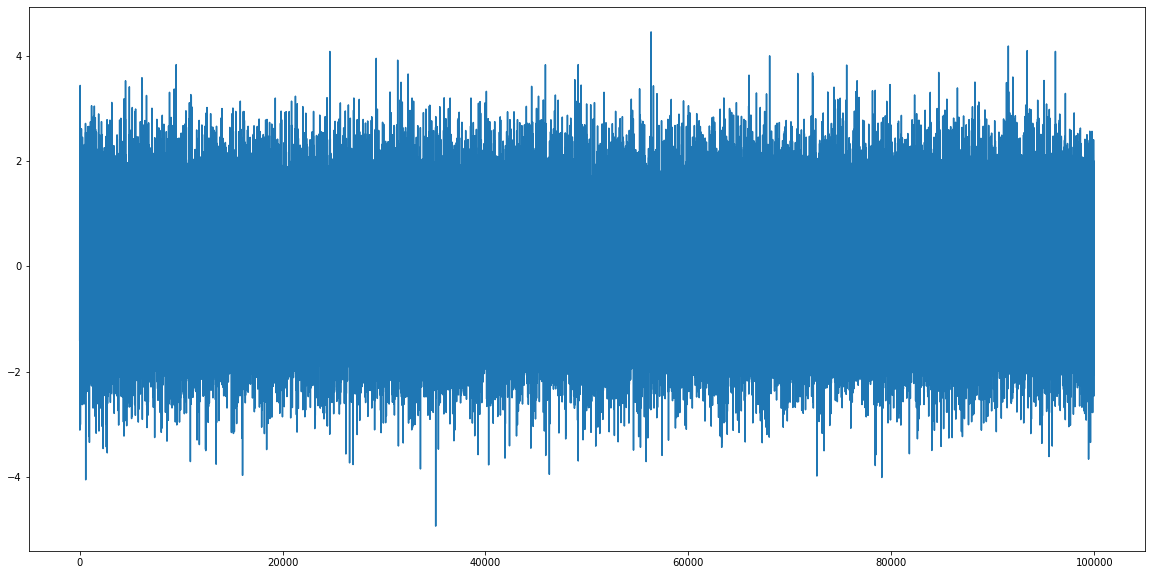

8 0


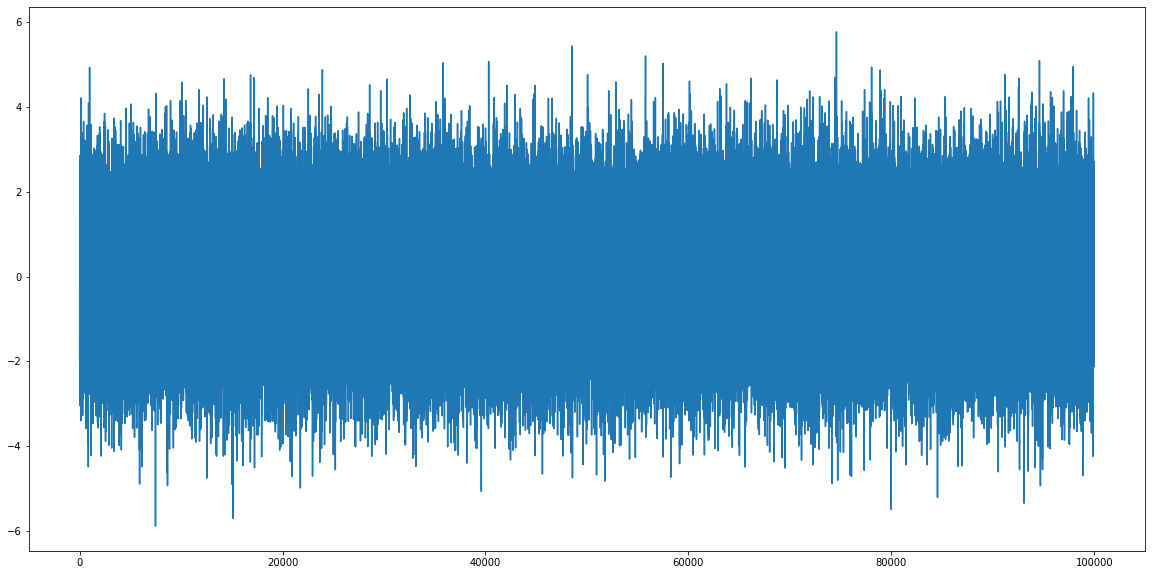

9 0


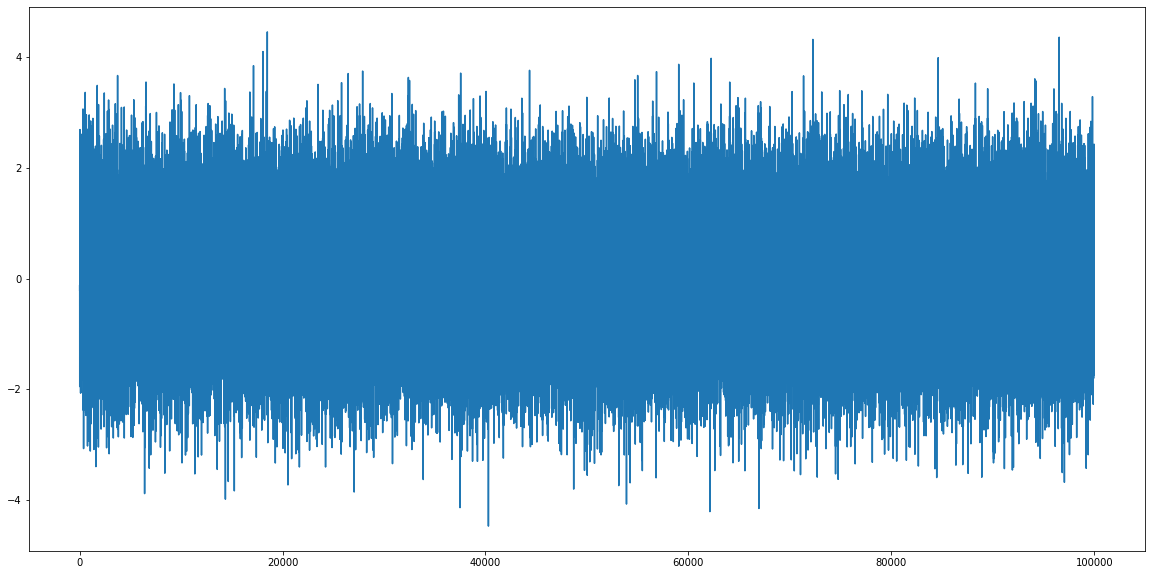

In [9]:
for i in range(len(Xs)):
    for j in range(Xs[i].shape[1]):
        plt.figure(figsize=(20, 10))
        print(i, j)
        plt.plot(Xs[i][:, j])
        plt.show()
        break

### Example of config 

In [10]:
print('Regressors')
print(configs[5][0])
print('Lags')
print(configs[5][1])
print('Signs')
print(configs[5][2])
print('Coefficients')
print(configs[5][3])

Regressors
{0: array([ 5, 11,  9, 14,  7,  1]), 1: array([2]), 2: array([3, 1, 0, 5]), 3: array([12,  5,  2]), 4: array([10,  0,  2, 12,  1,  8,  3, 14,  6]), 5: array([], dtype=int64), 6: array([ 3,  7,  5, 12,  0, 14,  4,  8,  2, 13]), 7: array([ 8,  2,  1,  3, 13]), 8: array([], dtype=int64), 9: array([ 1,  0,  6,  3, 12, 10,  4]), 10: array([ 0, 10,  4, 12]), 11: array([ 3, 14]), 12: array([ 5, 14,  0,  4,  2,  3, 12,  8]), 13: array([ 5,  1,  3, 11,  6,  7]), 14: array([ 7, 13,  4,  9,  5])}
Lags
{0: array([ 58, 106, 159,  97, 221, 204]), 1: array([97]), 2: array([125,  98, 150,  29]), 3: array([195, 210,  78]), 4: array([146, 117, 103, 207, 210, 112, 104,  42, 215]), 5: array([], dtype=int64), 6: array([223,  33,  47,  90,  56, 107, 197, 246, 108,  60]), 7: array([189, 106, 162, 139,  34]), 8: array([], dtype=int64), 9: array([ 64, 215, 171, 208, 168, 221,  28]), 10: array([151,  70, 236, 249]), 11: array([242, 245]), 12: array([249,  87,  93, 246,  89, 160, 128,   5]), 13: array

### Obtained equations

In [11]:
print("Equations obtained")
for k in range(len(configs)):
    print("Case ", k+1)
    for key in configs[k][0].keys():
        eq = "X{} = ".format(key)
        for  regr, ts, sign, coef in zip(configs[k][0][key], configs[k][1][key],
                                         configs[k][2][key], configs[k][3][key]):
            if(sign == 1):
                eq += "+"
            eq += str(sign*round(coef, 3)) + "X{}".format(regr) + "[t-{}]".format(ts) + " "
        eq += "+ n~N(0, 1)"
        print(eq)
        print("")

Equations obtained
Case  1
X0 = +0.129X7[t-249] -0.104X1[t-206] +0.374X4[t-55] -0.334X0[t-140] +0.341X2[t-89] + n~N(0, 1)

X1 = +0.235X1[t-182] +0.129X4[t-205] +0.149X2[t-122] -0.399X6[t-77] + n~N(0, 1)

X2 = -0.012X8[t-184] +0.106X7[t-200] + n~N(0, 1)

X3 = -0.312X6[t-140] -0.374X8[t-246] -0.035X9[t-136] -0.375X7[t-165] +0.072X1[t-60] -0.341X3[t-182] +0.209X4[t-174] +0.162X2[t-5] + n~N(0, 1)

X4 = -0.078X4[t-164] +0.201X3[t-213] -0.187X2[t-147] -0.037X1[t-89] + n~N(0, 1)

X5 = -0.239X8[t-78] -0.269X6[t-197] +0.254X5[t-187] +0.37X2[t-179] +0.1X1[t-69] +0.383X3[t-77] -0.073X9[t-84] +0.253X0[t-152] + n~N(0, 1)

X6 = +0.123X2[t-196] +0.241X5[t-152] + n~N(0, 1)

X7 = -0.267X6[t-221] -0.393X1[t-220] -0.286X4[t-151] -0.075X7[t-126] -0.256X9[t-247] +0.014X0[t-44] + n~N(0, 1)

X8 = +0.157X9[t-43] -0.185X3[t-73] +0.399X4[t-180] +0.199X7[t-131] -0.385X8[t-210] +0.355X0[t-21] + n~N(0, 1)

X9 = +0.103X2[t-86] +0.052X7[t-42] +0.126X1[t-2] + n~N(0, 1)

Case  2
X0 = -0.224X7[t-109] -0.353X1[t-124] +0

### Calculating dependencies for  randomly chosen targets

In [36]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class TCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.first_layer(x)
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
        x = x[..., -1]
        out = self.output_transform(x)
        return out.squeeze(1)
    
class TCNStack(nn.Module):
    def __init__(self, input_dim, n_layers, n_networks, n_channels=32, kernel_size=3):
        super().__init__()
        self.tcns = nn.ModuleList([TCN(input_dim, n_layers, n_channels, kernel_size) for _ in range(n_networks)])
        self.n_networks = n_networks
        self.output_transform = nn.Linear(self.n_networks, 1)
    def forward(self, x):
        step = x.shape[1]//self.n_networks
        outs = []
        for i in range(self.n_networks):
            out = self.tcns[i](x[:, i*step:(i+1)*step, :])
            outs.append(out.unsqueeze(1))
        outs = torch.cat(outs, dim=1)
        out = self.output_transform(outs)
        return out.squeeze(1)

In [37]:
m = TCNTemporalBlock(32, 64, 3, 4)

In [38]:
x = torch.randn(8, 32, 10)

In [39]:
y = m(x)

In [40]:
y.shape

torch.Size([8, 64, 10])

In [41]:
m = TCNStack(5, 6, 6)

In [42]:
x = torch.randn(8, 300, 5)

In [43]:
y = m(x)

In [44]:
y.shape

torch.Size([8])

In [45]:
depth = 300
epochs = 100
importance_calculation_steps = 20
early_stopping_epochs = 10

regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [46]:
maps = []
results = []

In [47]:
from tqdm import tqdm_notebook

In [50]:
for k in range(len(Xs)):
    print("Case: ", k+1)
    X = np.zeros((length, depth, Xs[k].shape[1]))
    for i in tqdm_notebook(range(Xs[k].shape[1])):
        for j in range(depth):
            X[:, j, i] = pd.Series(Xs[k][:, i]).shift(depth - j - 1).bfill()
    
    y = pd.Series(Xs[k][:, targets[k]]).shift(-1).ffill().values
    
    X_train = X[:train_length]
    X_test = X[train_length:]
    y_train = y[:train_length]
    y_test = y[train_length:]
    
    X_train_t = torch.Tensor(X_train)
    X_test_t = torch.Tensor(X_test)
    y_train_t = torch.Tensor(y_train)
    y_test_t = torch.Tensor(y_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)
    
    #model = TCNModel(X_train_t.shape[2], num_channels=[32] * 9, kernel_size=3, dropout=0.0).cuda()
    model = TCNStack(X_train_t.shape[2], 6, 6).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.8)
    loss = nn.MSELoss()
    
    
    val_loss = 999
    counter = 0
    
    print("Training")
    for e in range(epochs):
        train_loss = 0
        model.train()
        for batch_x, batch_y in tqdm_notebook(train_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            output = model(batch_x)
            l = loss(output, batch_y)
            l.backward()
            opt.step()
            train_loss+=l.item()*batch_x.shape[0]
        true = []
        preds = []
        model.eval()
        sc.step()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.cuda()
                output = model(batch_x)
                true.append(batch_y.numpy())
                preds.append(output.detach().cpu().numpy())
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        mse = mean_squared_error(true, preds)
        r2 = r2_score(true, preds)
        print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
        if val_loss > mse:
            val_loss = mse
            torch.save(model.state_dict(), "tcn_stck{}.pt".format(k))
        else:
            counter += 1
        
        if counter == early_stopping_epochs:
            break
    model.load_state_dict(torch.load('tcn_stck{}.pt'.format(k)))
    
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    model.eval()
    
    print("Calculating Importance:")
    importance_map = []
    for batch_x, batch_y in tqdm_notebook(test_loader):
        batch_x = batch_x.cuda()
        #batch_y = batch_y.cuda()
        bx = batch_x
        y = model(batch_x)
        mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
        opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
        for e in range(importance_calculation_steps):
            opt.zero_grad()
            model.zero_grad()
            model.eval()
            y = y.detach()
            M = torch.sigmoid(mask)
            x_hat = bx*M
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff1*torch.sum(torch.abs(M))
            ones = torch.zeros_like(bx)
            ones[M>0.5] = 1
            l += 0.5*bce_loss(M, ones)
            l.backward()
            opt.step()
        M = torch.sigmoid(mask)
        #ms = ms.detach().cpu().numpy()
        thresholds = {}
        with torch.no_grad():
            for t in np.linspace(M.min().item(), M.max().item(), 100):
                M_clone = M.clone()
                M_clone[M_clone>t] = 1
                M_clone[M_clone<=t] = 0
                x_hat = bx*M_clone
                y_hat = model(x_hat)
                l = mse_loss(y_hat, y)
                l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
                thresholds[l.item()] = t
        t = thresholds[min(thresholds.keys())]
        M = M.detach().cpu().numpy()
        M[M>t] = 1
        M[M<=t] = 0
        importance_map.append(np.abs(M))
        
    importance_map = np.concatenate(importance_map)
    importance_map = np.mean(importance_map, axis=0)
    
    maps.append(importance_map)
    result = {}
    for i in range(importance_map.shape[1]):
        max_val = importance_map[:, i].max()
        if max_val > importance_threshold:
            timestep = importance_map.shape[0] - np.argmax(importance_map[:, i])
            result[i] = timestep
    
    FP, TP, FN = 0, 0, 0
    for regr, ts in zip(configs[k][0][targets[k]], configs[k][1][targets[k]]):
        predicted_timestep = result.get(regr)
        if predicted_timestep is None:
            FN += 1
        elif predicted_timestep != ts:
            FP += 1
            FN += 1
        else:
            TP += 1

    for regr in result.keys():
        if regr not in configs[k][0][targets[k]]:
            FP += 1
            
    precision = TP/(TP + FP + 1e-9)
    recall = TP/(TP + FN + 1e-9)
    print("Results: ", precision, recall)
    results.append([precision, recall])

Case:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.6434655565738678 mse:  1.5610043 r2:  0.15338596923952608


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.4221596851825715 mse:  1.3111514 r2:  0.28889421681378147


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.2734116666793822 mse:  1.3023688 r2:  0.29365751083678915


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.2289353711128235 mse:  1.2667744 r2:  0.3129621273946326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1808350323677064 mse:  1.2329063 r2:  0.3313305628762204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1449882057189942 mse:  1.2344432 r2:  0.3304971014487593


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1195259343147277 mse:  1.2285113 r2:  0.3337142035193592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.0451661955118179 mse:  1.106963 r2:  0.399636225610553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9687663101196289 mse:  1.1024913 r2:  0.40206151023687475


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.940574456524849 mse:  1.116954 r2:  0.3942176186978583


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.901809516453743 mse:  1.1233615 r2:  0.39074253759267386


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.876526917719841 mse:  1.1590225 r2:  0.37140164422138233


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.8520522415876388 mse:  1.158615 r2:  0.37162262637492016


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.8244570199728012 mse:  1.202522 r2:  0.3478095237990815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.7978742692708969 mse:  1.2228397 r2:  0.3367902534107453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  0.7731889569759369 mse:  1.2509571 r2:  0.3215407175741678


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  0.749269181895256 mse:  1.2395533 r2:  0.32772554186438463


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  17 train:  0.722061172413826 mse:  1.2601051 r2:  0.3165792963051349
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998571428 0.874999999890625
Case:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.0686819514751433 mse:  1.0661478 r2:  0.11995304905589954


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.025728372335434 mse:  1.0436642 r2:  0.13851210282899373


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0163752437114715 mse:  1.0468254 r2:  0.13590264998064983


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.008009523010254 mse:  1.0495688 r2:  0.13363816453414468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  0.9981158423185349 mse:  1.0599482 r2:  0.12507051490505627


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9876890303134919 mse:  1.0595429 r2:  0.12540515555899612


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9712363475322724 mse:  1.0716612 r2:  0.11540207991526252


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9511905795097351 mse:  1.0951672 r2:  0.09599921643414377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9290351957321167 mse:  1.1147982 r2:  0.0797949185863781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9023353997945786 mse:  1.1336484 r2:  0.0642350889621246


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.8605637596130371 mse:  1.1672972 r2:  0.036459875347626514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.8281022609949112 mse:  1.1896619 r2:  0.017998984392833983
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.6666666664444444
Case:  3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.4468743997097016 mse:  1.3238118 r2:  0.1770808043532598


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.2830027158260346 mse:  1.2860097 r2:  0.20057961652737766


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.2222342744350434 mse:  1.239472 r2:  0.2295087612786233


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.1639446493148804 mse:  1.1920133 r2:  0.25901045344019036


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1053224961280823 mse:  1.1395451 r2:  0.2916261238080735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.0571226793289183 mse:  1.1383108 r2:  0.29239345252754734


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0274742861270905 mse:  1.1261483 r2:  0.2999540286315725


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9992307851314545 mse:  1.1478101 r2:  0.28648842222120363


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9616279284954071 mse:  1.1306971 r2:  0.2971263095425518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9327671691179276 mse:  1.156492 r2:  0.28109153758103167


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.8890717707633972 mse:  1.1894008 r2:  0.26063446628987097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.8601444190740586 mse:  1.1841425 r2:  0.2639032275979324


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.8314355626106262 mse:  1.2124225 r2:  0.24632353174257582


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.8006636155366897 mse:  1.2423968 r2:  0.2276905663409532


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.7748923578739166 mse:  1.2519281 r2:  0.2217657218575746


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  0.7456699701309204 mse:  1.2742685 r2:  0.20787820560949521


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  0.7148705534219741 mse:  1.3422347 r2:  0.16562849150244874
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.8888888887901234 0.571428571387755
Case:  4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.095576000404358 mse:  1.0697396 r2:  0.06267625675825073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.0632031414985657 mse:  1.0763209 r2:  0.0569096837398837


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.05757272233963 mse:  1.0677067 r2:  0.06445746205958758


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0533145971775055 mse:  1.068336 r2:  0.06390610098670901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0348744031906127 mse:  1.0311012 r2:  0.09653190006357515


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.0064880410671233 mse:  1.0234871 r2:  0.10320347747232272


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9955163468837738 mse:  1.0218502 r2:  0.10463782742570304


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9875482626914978 mse:  1.0266446 r2:  0.10043683645845647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9772671273708343 mse:  1.0304211 r2:  0.09712778014807222


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.964817623758316 mse:  1.030998 r2:  0.09662232956614791


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9430911307811737 mse:  1.0404615 r2:  0.08833016589745546


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.9265840874195099 mse:  1.076471 r2:  0.056778068255836533


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.9075286899805068 mse:  1.0777509 r2:  0.05565668737654039


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.889481786108017 mse:  1.0885769 r2:  0.04617061682844559


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.8679839621067047 mse:  1.0991067 r2:  0.036944416865308805
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.6666666664444444 0.6666666664444444
Case:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.0006763300418853 mse:  1.0031734 r2:  -0.00034363061131026384


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  0.9988965133428573 mse:  1.0007694 r2:  0.0020537114018968072


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  0.9967111259698868 mse:  1.0010779 r2:  0.001745969110019896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  0.9937701201915741 mse:  1.0028673 r2:  -3.830319399700244e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  0.9894102974891663 mse:  1.007283 r2:  -0.004441649921083535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9832420497894288 mse:  1.0113126 r2:  -0.008459861506485478


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9741519829273224 mse:  1.018075 r2:  -0.015203208802643697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9618526893138886 mse:  1.0280514 r2:  -0.0251514210260515


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9443906985759735 mse:  1.039048 r2:  -0.0361169503823604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9264350902557373 mse:  1.0550741 r2:  -0.052097856819737


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.8947163441419601 mse:  1.1013997 r2:  -0.09829277383410706


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.8679180406570435 mse:  1.1123505 r2:  -0.1092127712411246
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.9999999989999999
Case:  6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.2348960765361785 mse:  1.119107 r2:  0.2037190709739869


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.084685749387741 mse:  1.1138489 r2:  0.2074603188485049


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.070561633491516 mse:  1.1120259 r2:  0.20875751140470766


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0595362632751464 mse:  1.111721 r2:  0.20897431525370092


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0477131837368012 mse:  1.1205275 r2:  0.2027082536444499


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.032550647687912 mse:  1.127482 r2:  0.19775994850517142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0134560657501221 mse:  1.1515816 r2:  0.180612321118354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9913470125675201 mse:  1.1737062 r2:  0.16486994341561778


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.966964044713974 mse:  1.1889846 r2:  0.1539988282960123


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9374248469829559 mse:  1.2016275 r2:  0.14500300781826658


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.8887355488538742 mse:  1.2439008 r2:  0.11492421874278735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.855201322555542 mse:  1.2701043 r2:  0.0962795068661414


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.8208125944137573 mse:  1.3094015 r2:  0.06831831850578463


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.7876143427610397 mse:  1.3247837 r2:  0.05737339335686298
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999996666666 0.59999999988
Case:  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.0465207399368286 mse:  1.010004 r2:  0.10190473338253891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.009172986459732 mse:  1.0073197 r2:  0.10429149917364833


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0049269953250886 mse:  1.0125248 r2:  0.09966310884455432


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0011154840707779 mse:  1.0126041 r2:  0.09959275784235311


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  0.9970353388309479 mse:  1.011088 r2:  0.10094085923337615


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9916122428894043 mse:  1.0137504 r2:  0.09857333544222069


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9833446622848511 mse:  1.01931 r2:  0.09362980926678188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9739302798986434 mse:  1.0238134 r2:  0.08962548483388655


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9615212530374527 mse:  1.0478187 r2:  0.06827994548310823


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.945163072180748 mse:  1.052233 r2:  0.06435471619301214


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9183262512207031 mse:  1.073595 r2:  0.04535954687313726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.8946831648826599 mse:  1.0853149 r2:  0.034938423303493504
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.9999999995
Case:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.244138087415695 mse:  1.0747477 r2:  0.3329693359611553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.070372193288803 mse:  1.0636644 r2:  0.3398480327218716


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0471668098926543 mse:  1.0728828 r2:  0.3341267957970572


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.023536655020714 mse:  1.0350522 r2:  0.35760597351648604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0037184267044068 mse:  1.1111377 r2:  0.31038422616718375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9914388616085053 mse:  1.048948 r2:  0.3489816116327119


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.972559336733818 mse:  1.0532702 r2:  0.34629917382265185


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9499688376903533 mse:  1.0579898 r2:  0.3433699696819238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9299123026132584 mse:  1.0632963 r2:  0.34007651621740376


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9070938791990281 mse:  1.1011984 r2:  0.31655301209441067


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.8698775888919831 mse:  1.1254479 r2:  0.3015028597533913


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.841851779794693 mse:  1.1197654 r2:  0.3050296168345884


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.8146691966295242 mse:  1.1361349 r2:  0.29487001389104217
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998571428 0.874999999890625
Case:  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.4604477338314057 mse:  1.3367844 r2:  0.3147830282574422


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.277774891757965 mse:  1.2943118 r2:  0.33655398292702854


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.2410863752365113 mse:  1.2971108 r2:  0.33511916467674663


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.2090916156768798 mse:  1.2621602 r2:  0.35303440373265493


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1866033007621766 mse:  1.2579408 r2:  0.35519709725820525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1671401280879974 mse:  1.2579309 r2:  0.35520225008551976


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1370083905696868 mse:  1.2660768 r2:  0.3510267583379091


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1128365354537963 mse:  1.2540348 r2:  0.35719936133239716


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.088219281244278 mse:  1.2840334 r2:  0.34182243994514017


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0624265699386597 mse:  1.3010061 r2:  0.333122486196165


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.015385099220276 mse:  1.3017446 r2:  0.33274399438888635


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.9883762727737426 mse:  1.3353957 r2:  0.31549488389072977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.9587572779178619 mse:  1.3472234 r2:  0.30943207849029675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.9287567242860794 mse:  1.3802271 r2:  0.29251494270137124


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.9008293875217438 mse:  1.4141705 r2:  0.2751160052286875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  0.8755343260765076 mse:  1.4264697 r2:  0.2688116250828406
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998333333 0.5454545454049586
Case:  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1831601338386535 mse:  1.1269455 r2:  0.16068282099093545


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.1248916155338287 mse:  1.1243693 r2:  0.16260148625814852


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.1172715600967407 mse:  1.1215634 r2:  0.16469118863133647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.106100679540634 mse:  1.1262031 r2:  0.16123577146455914


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0935023315429688 mse:  1.1258718 r2:  0.16148253302938942


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.081043341732025 mse:  1.1283983 r2:  0.15960081977011364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0662784126758575 mse:  1.1386441 r2:  0.15197002994129527


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.050394596672058 mse:  1.141719 r2:  0.14967986279541357


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.031270323753357 mse:  1.1578691 r2:  0.13765175763972615


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0003827821731568 mse:  1.1524887 r2:  0.14165897061095878


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9631074090480805 mse:  1.1774431 r2:  0.12307356716079931


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.9384542376995086 mse:  1.1870035 r2:  0.11595328653109405


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.9115233950138092 mse:  1.2277627 r2:  0.08559705280426178
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.499999999875


In [51]:
for i, r in enumerate(results):
    print('Case {}'.format(i+1))
    print('Precision', 'Recall')
    print(r)

Case 1
Precision Recall
[0.9999999998571428, 0.874999999890625]
Case 2
Precision Recall
[0.9999999995, 0.6666666664444444]
Case 3
Precision Recall
[0.8888888887901234, 0.571428571387755]
Case 4
Precision Recall
[0.6666666664444444, 0.6666666664444444]
Case 5
Precision Recall
[0.9999999989999999, 0.9999999989999999]
Case 6
Precision Recall
[0.9999999996666666, 0.59999999988]
Case 7
Precision Recall
[0.9999999995, 0.9999999995]
Case 8
Precision Recall
[0.9999999998571428, 0.874999999890625]
Case 9
Precision Recall
[0.9999999998333333, 0.5454545454049586]
Case 10
Precision Recall
[0.9999999995, 0.499999999875]


### Visual estimation of resulted importance heatmaps

Case 1


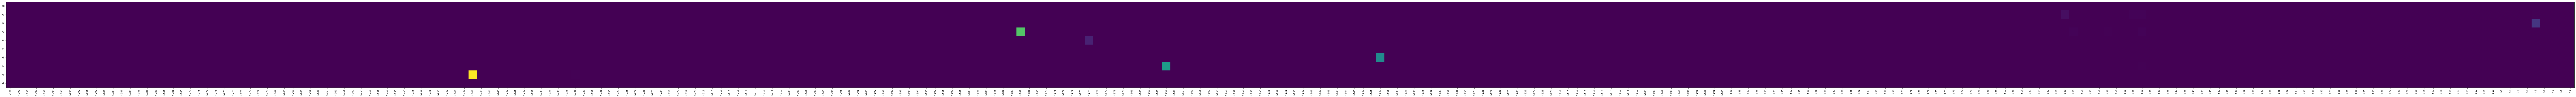

Case 2


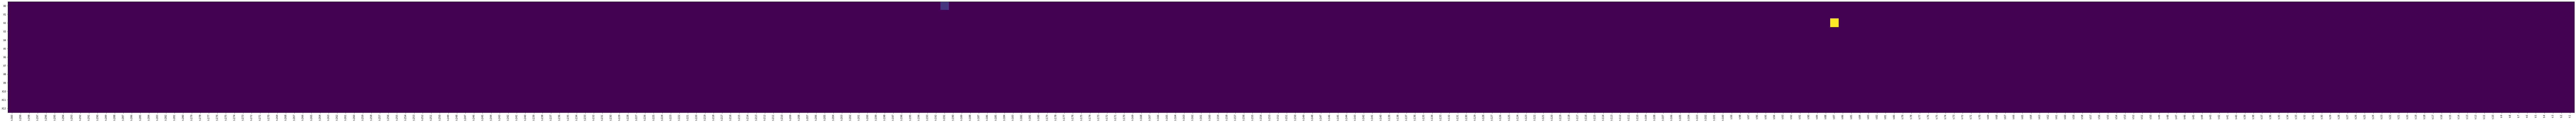

Case 3


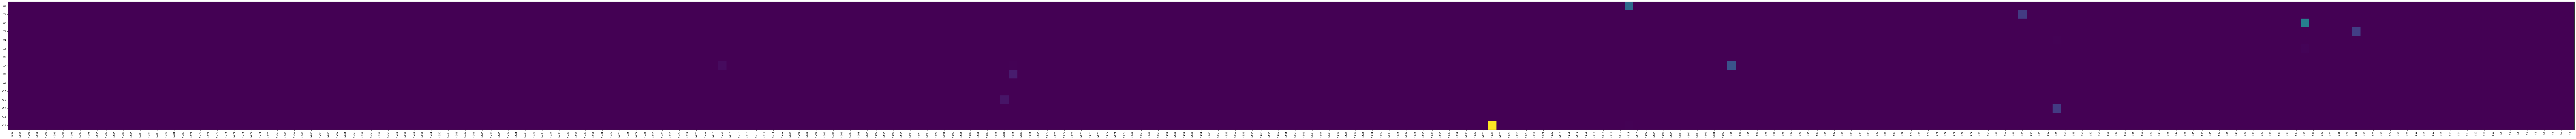

Case 4


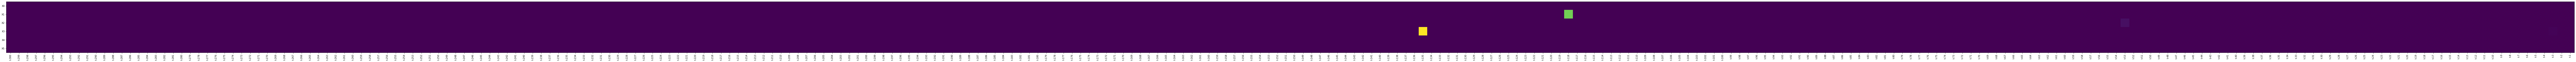

Case 5


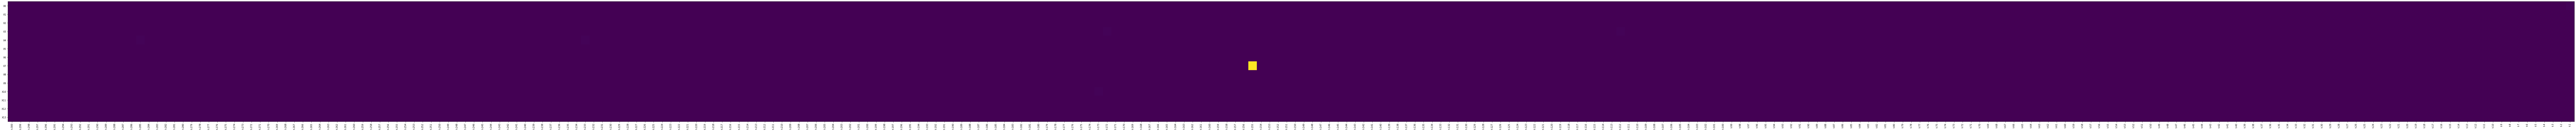

Case 6


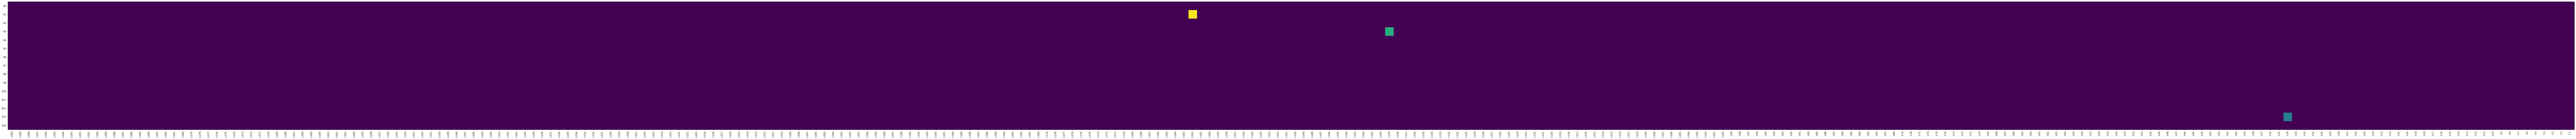

Case 7


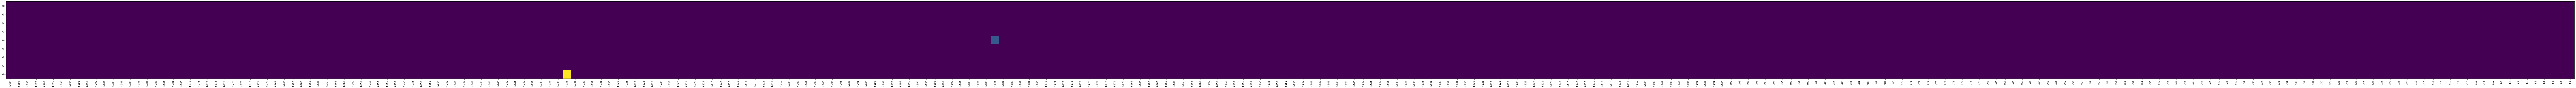

Case 8


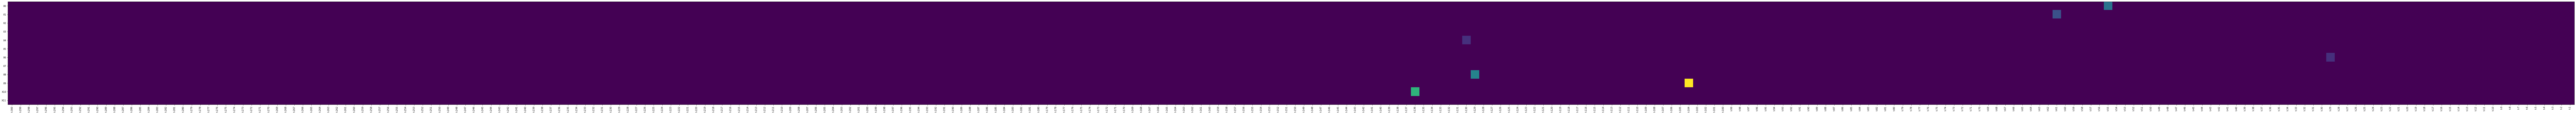

Case 9


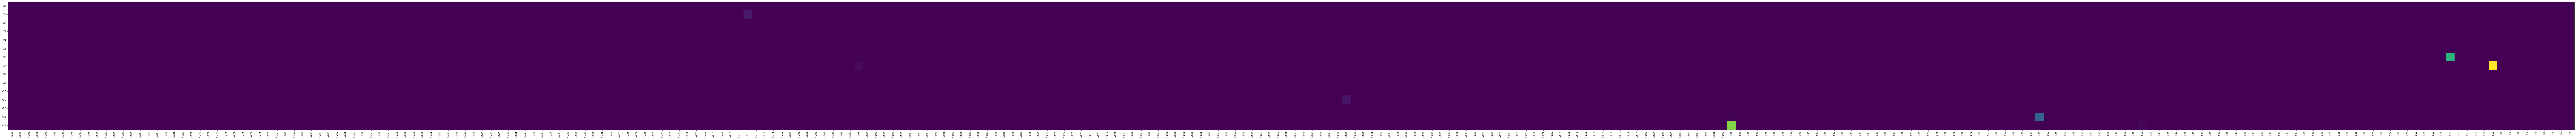

Case 10


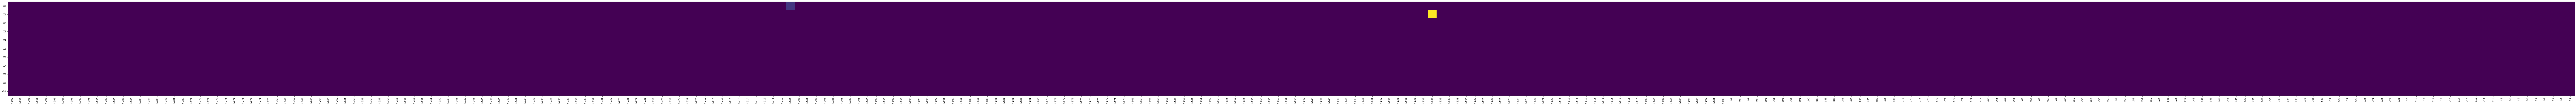

In [52]:
for i in range(number_of_experiments):
    print('Case {}'.format(i+1))
    fig, ax = plt.subplots(figsize=(200, 100))
    ax.imshow(maps[i].T)
    ax.set_xticks(np.arange(depth))
    ax.set_xticklabels(["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
    ax.set_yticks(np.arange(Xs[i].shape[1]))
    ax.set_yticklabels(["X{}".format(i) for i in range(Xs[i].shape[1])])
    plt.show()